# Amazon Stock Direction Multi-Class Classification Model
-----------------

### Target Creation
 * The target of the below dataset is the column 'Direction'. It is a multiclass variable with a performance window of 60 minutes with the following classes:
   - 0: Stock is neutral during the performance window.
   - 1: Stock is going up within the performance window
   - 2: Stock is going down within the performance window
 * 60 minutes is chosen as the best window of time because it has enough variance to add data points to each class but also represents a good window of time where there may not be a vast amount of variance in between.
 * The classification of up and down is based on a threshold of the stock moving up or down 1% in that hour.
 * Below we will show some baseline stats for the target variable and define the prediction period we will use.

In [4]:
from IPython.display import display, HTML


def dataframe_to_html(df):
    """
    Convert a DataFrame to an HTML table.

    Parameters:
    df (pd.DataFrame): The DataFrame to convert.

    Returns:
    str: The HTML representation of the DataFrame.
    """
    # Convert the DataFrame to an HTML table
    html = df.to_html()
    
    # Return the HTML string
    return html



def htmldf(df):
    """
    Display a DataFrame as an HTML table in a Jupyter notebook.

    Parameters:
    df (pd.DataFrame): The DataFrame to display.
    """
    # Convert the DataFrame to an HTML table
    html = dataframe_to_html(df)
    
    # Display the HTML table
    display(HTML(html))

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

filtered_df = pd.read_csv('amzn_preprocessed_final.csv')
htmldf(filtered_df.head(10))

,timestamp,close,AD,OBV,TOS_STDEVALL_LR,MSFT,GOOGL,META,WMT,BABA,peak,epeak,valley,evalley,g_peak,m_peak,w_peak,b_peak,ms_peak,g_valley,m_valley,w_valley,b_valley,ms_valley,A_B_ratio,A-B,A-G,A-MS,close_diff_1,close_diff_2,close_diff_3,close_diff_4,close_diff_5,Close_Discretized,Direction
0,2023-08-07 18:38:00+00:00,141.980,55506.779414,99508.0,126.08766,329.860,131.090,314.61,160.74,96.1928,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1.475994,45.7872,10.890,-187.880,-0.040,-0.130,-0.120,-0.160,-0.190,1.0,0
1,2023-08-07 18:39:00+00:00,141.980,55341.989940,99508.0,126.08766,329.715,131.075,314.39,160.74,96.1928,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1.475994,45.7872,10.905,-187.735,0.000,-0.040,-0.130,-0.120,-0.160,1.0,0
2,2023-08-07 18:40:00+00:00,141.990,57382.989940,101549.0,126.08766,329.735,131.085,314.34,160.70,96.1928,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1.476098,45.7972,10.905,-187.745,0.010,0.010,-0.030,-0.120,-0.110,1.0,0
3,2023-08-07 18:41:00+00:00,142.010,58064.418511,103139.0,126.08766,329.720,131.120,314.34,160.69,96.1928,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1.476306,45.8172,10.890,-187.710,0.020,0.030,0.030,-0.010,-0.100,1.0,0
4,2023-08-07 18:42:00+00:00,142.040,58222.418511,104245.0,126.08766,329.630,131.055,314.34,160.66,96.1928,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1.476618,45.8472,10.985,-187.590,0.030,0.050,0.060,0.060,0.020,1.0,0
5,2023-08-07 18:43:00+00:00,141.940,50355.418511,96378.0,126.08766,329.630,131.080,314.34,160.67,96.1928,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1.475578,45.7472,10.860,-187.690,-0.100,-0.070,-0.050,-0.040,-0.040,1.0,0
6,2023-08-07 18:44:00+00:00,141.975,51583.918511,98016.0,126.08766,329.500,131.080,314.34,160.67,96.1928,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.475942,45.7822,10.895,-187.525,0.035,-0.065,-0.035,-0.015,-0.005,1.0,0
7,2023-08-07 18:45:00+00:00,142.045,52030.318511,98574.0,126.08766,329.510,131.105,314.46,160.67,96.1928,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.476670,45.8522,10.940,-187.465,0.070,0.105,0.005,0.035,0.055,1.0,0
8,2023-08-07 18:46:00+00:00,142.130,52894.747083,100591.0,126.08766,329.530,131.180,314.46,160.67,96.1928,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1.477553,45.9372,10.950,-187.400,0.085,0.155,0.190,0.090,0.120,1.0,0
9,2023-08-07 18:47:00+00:00,142.060,53506.747083,99979.0,126.08766,329.530,131.140,314.46,160.67,96.1928,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.476826,45.8672,10.920,-187.470,-0.070,0.015,0.085,0.120,0.020,1.0,0


* The plot below shows the class proportions for each of the directional classifiers within the data-set

In [6]:
filtered_df['Direction'].isna().sum()

0

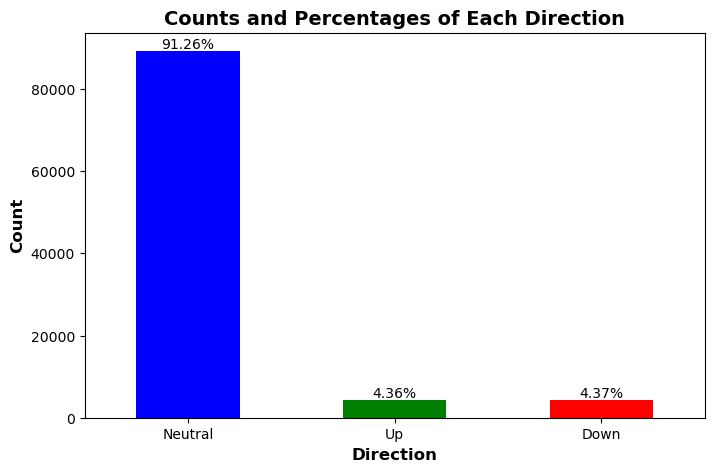

In [7]:
direction_counts = filtered_df['Direction'].value_counts().sort_index()

# Calculate the percentage of each group
direction_percentages = (direction_counts / direction_counts.sum()) * 100

# Plot the counts
plt.figure(figsize=(8, 5))
bars = direction_counts.plot(kind='bar', color=['blue', 'green', 'red'])

# Add percentage labels on top of the bars
for bar, percentage in zip(bars.patches, direction_percentages):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f'{percentage:.2f}%',
        ha='center',
        va='bottom',
        fontsize=10,
        
    )

plt.title('Counts and Percentages of Each Direction',fontsize = 14, fontweight = 'bold')
plt.xlabel('Direction',fontsize=12,fontweight='bold')
plt.ylabel('Count',fontsize=12,fontweight = 'bold')
plt.xticks(ticks=[0, 1, 2], labels=['Neutral', 'Up', 'Down'], rotation=0)
plt.show()

In [8]:
filtered_df['Direction'].value_counts()

Direction
0    89196
2     4275
1     4263
Name: count, dtype: int64

* Above we can see there class weights for the up and down classes is about even while the neutral class makes up the majority of the data, this is expected when dealing with stock pricing.
------------------------

### Prediction Period

Three different prediction periods will be tested, and the most accurate will be chosen for the final model:

- **Period 1**: 3 days - 1,170 rows
- **Period 2**: 1 week - 1,950 rows
- **Period 3**: 2 weeks - 3,900 rows

These periods were selected because the data is minute-to-minute, suggesting a semi-high frequency trading model. The 3-day period can capture short-term trends, while the 1-week and 2-week periods can reveal intraday patterns.


In [9]:
# Function for splitting data without overlap
def split_data(df, validation_start, test_start):
    # Split into training, validation, and test sets
    train_df = df[:validation_start]
    validation_df = df[validation_start:test_start]
    test_df = df[test_start:]
    return train_df, validation_df, test_df

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

def train_validate_and_evaluate_model(train_df, validation_df, lookback_period, target_column='Direction'):
    y_true_val = []
    y_pred_val = []
    
    # Iterate over the data to create rolling windows
    for end in range(lookback_period, len(train_df)):
        start = end - lookback_period
        train_subset = train_df.iloc[start:end]
        test_subset = validation_df
        
        # Ensure there's data to train on
        if train_subset.shape[0] == 0 or test_subset.shape[0] == 0:
            continue
        
        # Define features and target
        X_train = train_subset.drop(columns=[target_column])
        y_train = train_subset[target_column]
        X_val = test_subset.drop(columns=[target_column])
        y_val = test_subset[target_column]
        
        # Train the model
        model = RandomForestClassifier()
        model.fit(X_train, y_train)
        
        # Make predictions on validation data
        y_pred_val.extend(model.predict(X_val))
        y_true_val.extend(y_val)
    
    # Evaluate the model on validation data
    print(f"Lookback period: {lookback_period}")
    print("Validation Set Performance:")
    print(classification_report(y_true_val, y_pred_val))

    return y_true_val, y_pred_val

In [ ]:
filtered_df = filtered_df.drop(columns='timestamp')
# Define your splits
validation_start = int(len(filtered_df) * 0.7)  # 70% training data
test_start = int(len(filtered_df) * 0.9)        # 20% validation data

# Split the data
train_df, validation_df, test_df = split_data(filtered_df, validation_start, test_start)

# Train, validate, and evaluate models
lookback_periods = [1170, 1950, 3900]

for period in lookback_periods:
    train_validate_and_evaluate_model(train_df, validation_df, lookback_period=period, target_column='Direction')